# Granite Vision Multimodal RAG Demo

Welcome to this end-to-end **Multimodal Retrieval-Augmented Generation (RAG)** demo powered by the **Granite family** of foundation models.

This notebook demonstrates a complete multimodal RAG pipeline that performs **document-level question answering without OCR, layout analysis, or text extraction** — relying purely on **vision-language modeling**.

---

### 🔷 Models from the Granite Family Used

This demo utilizes the following Granite models:

- 🧠 **GraniteVisionEmbedding** – a retrieval-focused vision-language model based on contrastive learning and fine-tuned with LoRA adapters on `Granite-Vision 3.3–2b`.
- 🧾 **Granite-Vision 3.3–2b** – used for **multimodal generation**, capable of answering a user query given a document image.

> ⚠️ Note: While the code supports generating answers from multiple images, in this notebook we only use the **top-1 most relevant image** per query.

---

### 📊 End-to-End Workflow

1. **📥 PDF Download**  
   - A remote PDF file is downloaded and saved locally.

2. **🖼️ PDF Conversion to Images**  
   - The PDF is converted into page-level images using a lightweight renderer.

3. **🧠 Visual Indexing with GraniteVisionEmbeddingRetriever**  
   - Each page image is embedded using the GraniteVisionEmbedding model.
   - Embeddings are stored for retrieval.

4. **❓ Query Formulation**  
   - The user inputs a free-form natural language question.

5. **🔍 Retrieval of Relevant Pages**  
   - The question is embedded.
   - Similarity search retrieves the most relevant page(s).

6. **🧑‍🎨 Answer Generation with Granite-Vision**  
   - The top image and the query are passed together to Granite-Vision.
   - A grounded answer is generated using both modalities.

> 📌 *While multiple images can technically be passed to the model, we only use the top-1 result to keep the interaction simple and interpretable.*

---

### 📚 Notebook Sections

1. [Step 1: Define GraniteVisionEmbeddingRetriever](#step-1-define-granitevisionembedding-retriever)  
2. [Step 2: Convert PDF to Images](#step-2-convert-pdf-to-images)  
3. [Step 3: Initialize GraniteVisionEmbeddingRetriever](#step-3-initialize-granitevisionembedding-retriever)  
4. [Step 4: Embed and Index the PDF Pages](#step-4-embed-and-index-the-pdf-pages)  
5. [Step 5: Query and Retrieve Relevant Pages](#step-5-query-and-retrieve-relevant-pages)  
6. [Step 6: Generate Visual Response with Granite-Vision](#step-6-generate-visual-response-with-granite-vision)


### 🧰 Install & Import Dependencies

In [10]:
# Model dependencies
%pip install -q torch torchvision torchaudio
%pip install -q transformers==4.50.0 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Other dependencies (for PDF download & parsing, and visualization)
%pip install -q Pillow PyPDF2 PyMuPDF tqdm requests

Note: you may need to restart the kernel to use updated packages.


### 📥 Step 1: Define GraniteVisionEmbeddingRetriever
In this step, we define the `GraniteVisionEmbeddingRetriever()` class, which will be using the `ibm-granite/granite-vision-3.3-2b-embedding` model for pages retrieval.


In [6]:
import torch
from typing import ClassVar, List, Optional, TypeVar, Union
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [ ]:
# Define a generic type for datasets
import os
from transformers import AutoModel, AutoProcessor


T = TypeVar("T")

class ListDataset(Dataset[T]):
    def __init__(self, elements: List[T]):
        self.elements = elements

    def __len__(self) -> int:
        return len(self.elements)

    def __getitem__(self, idx: int) -> T:
        return self.elements[idx]
    
class GraniteVisionEmbeddingRetriever:

    emb_dim_query: ClassVar[int] = 128
    emb_dim_doc: ClassVar[int] = 128

    def __init__(
        self,
        model_name: str = "ibm-granite/granite-vision-3.3-2b-embedding",
        peft_path: str = None,
    ):
        self.device= "cuda:0" if torch.cuda.is_available() else "cpu"
        # Load the model and LORA adapter
        self.model = AutoModel.from_pretrained(
                model_name,
                trust_remote_code=True,
                torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        ).to(self.device).eval()
        self.processor = AutoProcessor.from_pretrained(
                model_name, 
                trust_remote_code=True,
                use_fast=True,
        )
        
    def process_images(self, images: List[Image.Image], **kwargs):
        return self.processor.process_images(images=images)

    def process_queries(self, queries: List[str], **kwargs):
        return self.processor.process_queries(queries=queries)

    def forward_queries(self, queries: List[str], batch_size: int, **kwargs) -> List[torch.Tensor]:
        dataloader = DataLoader(
            dataset=ListDataset[str](queries),
            batch_size=batch_size,
            shuffle=False,
            collate_fn=self.process_queries,
        )

        qs = []
        for batch_query in tqdm(dataloader, desc="Forward pass queries..."):
            with torch.no_grad():
                batch_query = {k: v.to(self.device) for k, v in batch_query.items()}
                embeddings_query = self.model(**batch_query)
                qs.extend(list(torch.unbind(embeddings_query)))

        return qs

    def forward_passages(self, passages: List[Image.Image], batch_size: int, **kwargs) -> List[torch.Tensor]:
        dataloader = DataLoader(
            dataset=ListDataset[Image.Image](passages),
            batch_size=batch_size,
            shuffle=False,
            num_workers=10,
            collate_fn=self.process_images,
        )

        ds = []
        for batch_doc in tqdm(dataloader, desc="Forward pass documents..."):
            with torch.no_grad():
                batch_doc = {k: v.to(self.device) for k, v in batch_doc.items()}
                embeddings_doc = self.model(**batch_doc)
            ds.extend(list(torch.unbind(embeddings_doc)))
        return ds

    def get_scores(
        self,
        query_embeddings: Union[torch.Tensor, List[torch.Tensor]],
        passage_embeddings: Union[torch.Tensor, List[torch.Tensor]],
        batch_size: Optional[int] = 128,
    ) -> torch.Tensor:
        if batch_size is None:
            raise ValueError("`batch_size` must be provided for ColPaliRetriever's scoring")
        scores = self.processor.score(
            query_embeddings,
            passage_embeddings,
            batch_size=batch_size,
            device=self.device,
        )
        return scores

### 📥 Step 2: Load PDF Report

In this step, we load an IBM AI report PDF using one of three available options:

- 🤗 **From the Hugging Face Hub**  
- 🌐 **From a public URL**  
- 📁 **From a local file path**

This PDF will be used as the source document for the multimodal RAG pipeline.  
Simply set the `mode` parameter in the code cell below to choose the desired loading method `modes=["hf", "url", "local"]`.  
⚠️ Make sure to change the sample queries bellow if you use a different PDF source.

In [ ]:
import os
import requests
from huggingface_hub import hf_hub_download

# Choose loading method: "hf", "url", or "local"
mode = "hf"

if mode == "hf":
    pdf_path = hf_hub_download(
        repo_id="ibm-granite/granite-vision-3.3-2b-embedding",
        filename="REPORT_Benchmarking the AI advantage in finance.pdf",
        local_dir=os.getcwd(),
    )
    print(f"[HF] PDF downloaded to: {pdf_path}")

elif mode == "url":
    url = "https://example.com/your_report.pdf"  # replace with real link
    pdf_path = "your_report.pdf"
    with open(pdf_path, "wb") as f:
        f.write(requests.get(url).content)
    print(f"[URL] PDF downloaded to: {pdf_path}")

elif mode == "local":
    pdf_path = "REPORT_Benchmarking the AI advantage in finance.pdf"  # change this path
    print(f"[Local] Using local PDF: {pdf_path}")

else:
    raise ValueError(f"Invalid mode: {mode}. Choose 'hf', 'url', or 'local'")


[HF] PDF downloaded to: /dccstor/mm-rag/idanfr/projects/colgranite_notebook_SA/demo/REPORT_Benchmarking the AI advantage in finance.pdf


### 🔍 Step 3: Initialize GraniteVisionEmbedding Retriever

We now initialize the **GraniteVisionEmbeddingRetriever**, a vision-language embedding model built by fine-tuning Granite-Vision with LoRA adapters (stored at the specified `peft_path`).  
This retriever is used to embed document pages and later retrieve the most relevant ones based on a query.

In [9]:
retriever = GraniteVisionEmbeddingRetriever()

Loading checkpoint shards: 100%|██████████| 3/3 [01:25<00:00, 28.40s/it]


### 🧠 Step 4: Embed and Index the PDF Pages

At this step, we pass the downloaded PDF.

- The pages are converted to images, then embedded using the `GraniteVisionEmbeddingRetriever` model.
- Embeddings are stored in an index for efficient retrieval later.


In [10]:
import fitz
from PIL import Image
from io import BytesIO

def convert_pdf_to_images(pdf_path: str, dpi: int = 200) -> List[Image.Image]:
    """
    Converts each page of a PDF file into a PIL image.
    Uses PyMuPDF (fitz) for fast and high-quality conversion.
    """
    images = []

    doc = fitz.open(pdf_path)
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        pix = page.get_pixmap(matrix=fitz.Matrix(dpi / 72, dpi / 72))
        img = Image.open(BytesIO(pix.tobytes("png")))
        images.append(img)

    return images


In [11]:
def index(pdf_paths: List[str], model: GraniteVisionEmbeddingRetriever):
    """
    Converts local PDF file paths to images and computes embeddings using the model.
    
    Args:
        pdf_paths (List[str]): List of local PDF file paths.
        model (GraniteVisionEmbeddingRetriever): The retriever model instance.

    Returns:
        Tuple[str, List[torch.Tensor], List[PIL.Image.Image]]:
            status message, list of embeddings, and list of images.
    """
    all_images = []

    for path in pdf_paths:
        if not path.lower().endswith(".pdf"):
            raise ValueError(f"Unsupported file type: {path}")
        
        images = convert_pdf_to_images(path)
        all_images.extend(images)

    embeddings = model.forward_passages(all_images, batch_size=10)

    return embeddings, all_images

In [12]:
### Run Indexing
embeddings, images = index([pdf_path], retriever)

Forward pass documents...: 100%|██████████| 3/3 [00:19<00:00,  6.60s/it]


### 🔎 Step 5: Query and Retrieve Relevant Pages

We now pose a **query** to the system — for example:

> *"How did termination fees impact rental income in January 2025?"*

Using the `GraniteVisionEmbeddingRetriever`, we:
- Embed the query
- Search the indexed page embeddings
- Retrieve the top-k most relevant page images

In [13]:
def search(
    model: GraniteVisionEmbeddingRetriever,
    query: str,
    doc_embeddings: List[torch.Tensor],
    top_n: int = 3
) -> List[int]:
    """
    Given a query and a list of document embeddings, compute similarity scores and return top matching images.

    Args:
        model: The retriever model.
        query: A single string query.
        doc_embeddings: Embeddings of the document pages.
        top_n: How many top results to return.

    Returns:
        Tuple of top indices and the corresponding images.
    """
    query_embeddings = model.forward_queries([query], batch_size=1)
    scores = model.get_scores(query_embeddings, doc_embeddings).cpu().numpy()
    top_indices = scores.argsort(axis=1).flatten()[-top_n:][::-1].tolist()
    return top_indices

In [14]:
queries = [
    "What percentage of finance organizations are using traditional AI for record-to-report in 2025?",
    "Which geographic region accounted for the largest share of CFO respondents, and what percentage did it represent?"
]
query = queries[0]  # you can manually change to queries[1]
top_indices = search(retriever, query, embeddings, top_n=3)

Forward pass queries...: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Display the top-retrieved image.

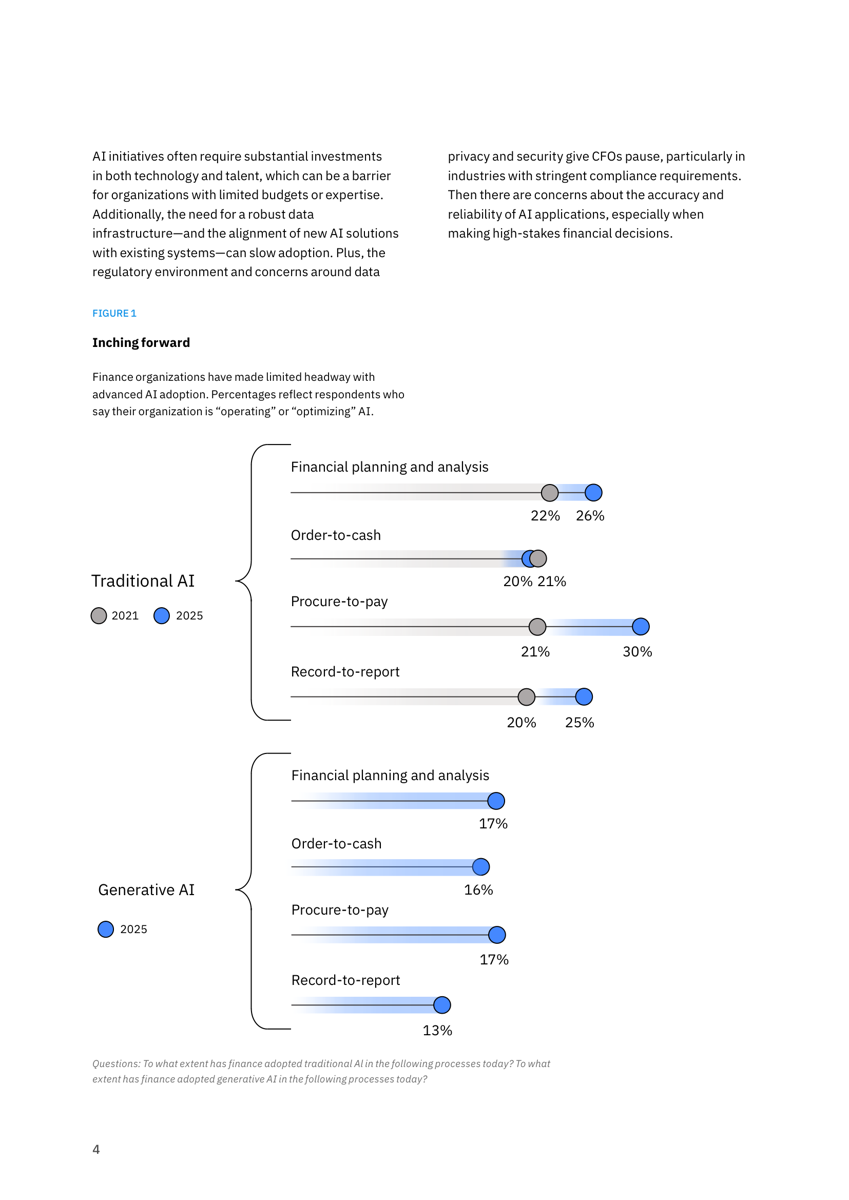

In [15]:
top_images = [images[i] for i in top_indices]
img = top_images[0].copy()
img.thumbnail((1200,1200))
img.show()


### 🧠 Step 6: Generate Visual Response with Granite-Vision
In this generation phase, we process the **most relevant retrieved page** using the **Granite-Vision 3.3** model to generate an answer grounded in visual context.

#### 🔧 What Happens in This Step:
- A **multimodal prompt** is built, combining the top-ranked image with the user query.
- The prompt is structured using `build_message()` and rendered with `apply_chat_template()`.
- The image and text are passed to Granite-Vision for generation.
- The model returns a concise answer, grounded in the selected image content.

#### 🛠️ Technical Notes:
- Generation uses a system prompt instructing the assistant to be helpful, detailed, and cautious.
- This approach avoids hallucinations from unrelated pages and promotes traceability.
- While this demo processes only one image, the underlying code and prompt structure are compatible with multi-image input. This enables future expansion to multi-page reasoning if needed.



In [ ]:
vlm_system_prompt = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. if there is not enough information say “I don’t know"


def build_message(pil_images, user_text, system_message=vlm_system_prompt):
    
    
    user_content =[]
    for pil_image in pil_images:
        user_content.append({
                        "type": "image",
                        "image": pil_image,
                    })
    user_content.append(                    {
                        "type": "text",
                        "text": user_text,
                    })
    return [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": user_content,
            }
    ]

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq

device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "ibm-granite/granite-vision-3.3-2b"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForVision2Seq.from_pretrained(model_path).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:58<00:00, 29.12s/it]


In [18]:
# prepare image and text prompt, using the appropriate prompt template
conversation = build_message([top_images[0]], query, vlm_system_prompt)

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(device)

In [19]:
# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0], skip_special_tokens=True))

<|system|>
A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. if there is not enough information say “I don’t know
<|user|>

What percentage of finance organizations are using traditional AI for record-to-report in 2025?
<|assistant|>
25%
